In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from sklearn.utils import shuffle
import cv2  

from datacube import Datacube
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

import tensorflow as tf
import os
import random

from skimage.io import imread, imshow
from skimage.transform import resize

dc = Datacube(app="Getting started")

IMG_WIDTH = 512
IMG_HEIGHT = 512

linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))
def clean_name(name):
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res

vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)

gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
X_test = np.load('X_test_pp.npy')

In [3]:
model = tf.keras.models.load_model('best_resnet_443_pp.h5')

In [4]:
preds = model.predict(X_test, verbose=1)
preds = np.squeeze(preds)

1/1 [==============================] - 0s 6ms/step


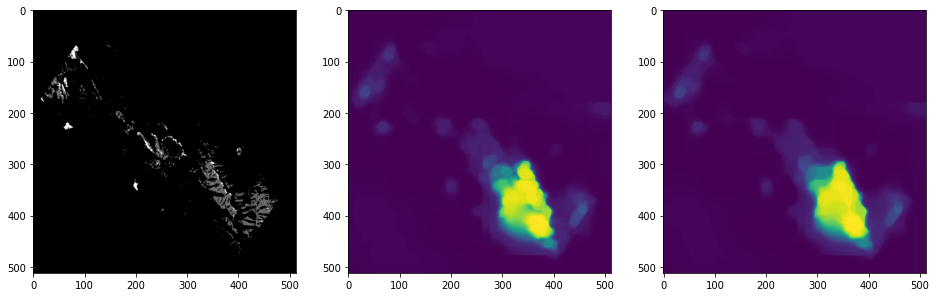

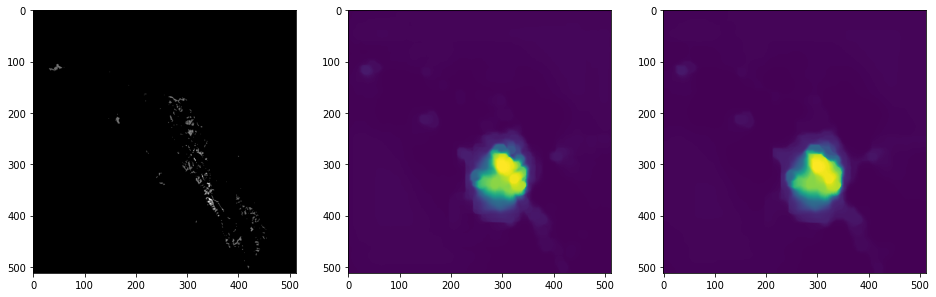

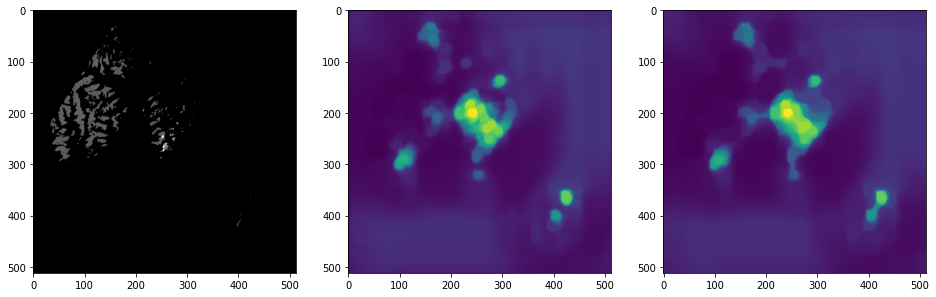

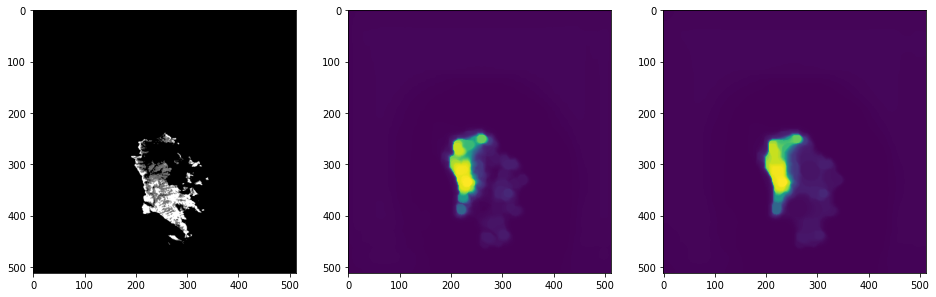

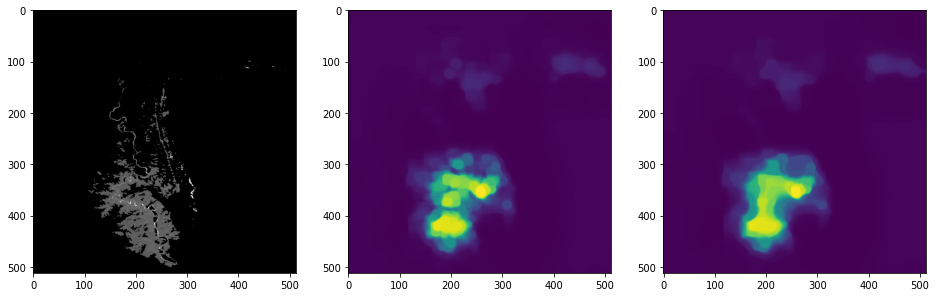

In [18]:
threshold = 0.1
kopen = 16
kclose = 32

for i in range(preds.shape[0]):
    # pred = np.where(preds[i] < threshold, 0, 1).astype(np.uint8)
    pred = preds[i]
    
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kopen,kopen))
    pred = cv2.morphologyEx(pred,cv2.MORPH_OPEN,kernelOpen)
    
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kclose,kclose))
    pred2 = cv2.morphologyEx(pred,cv2.MORPH_CLOSE,kernelClose)
    
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 3, 1)
    plt.imshow(X_test[i])
    f.add_subplot(1, 3, 2)
    plt.imshow(pred)
    f.add_subplot(1, 3, 3)
    plt.imshow(pred2)
    plt.show(block=True)

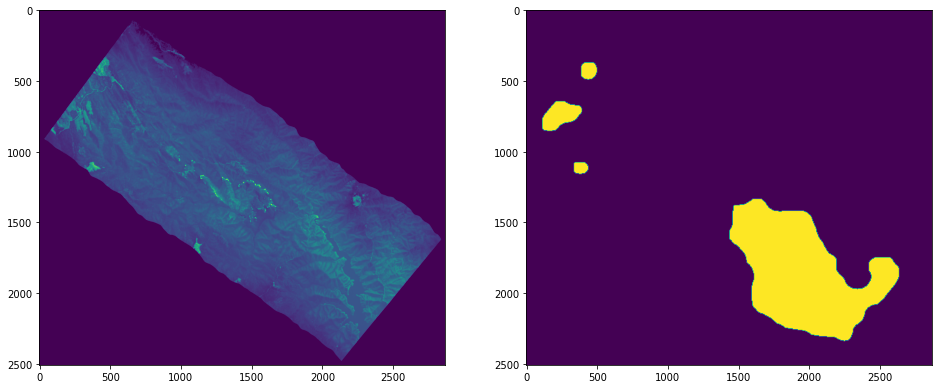

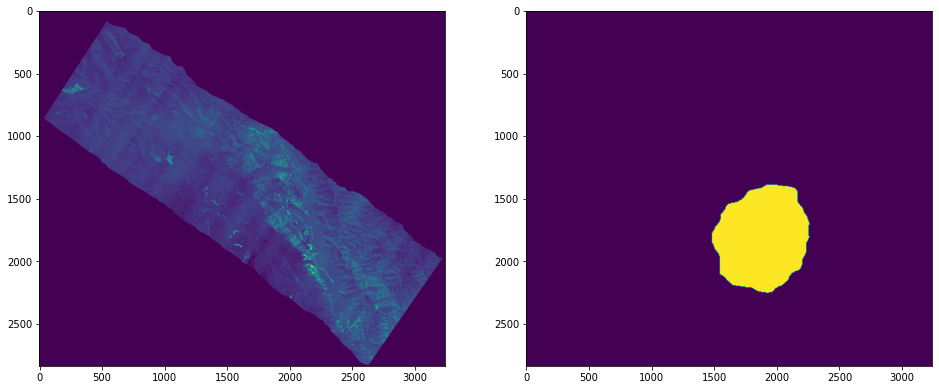

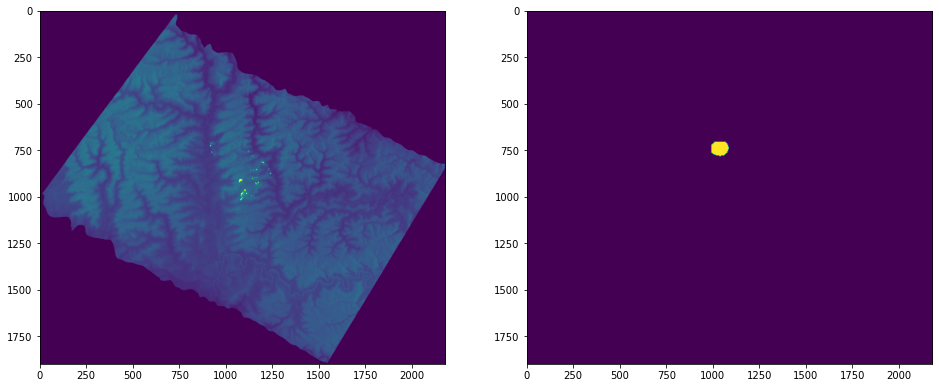

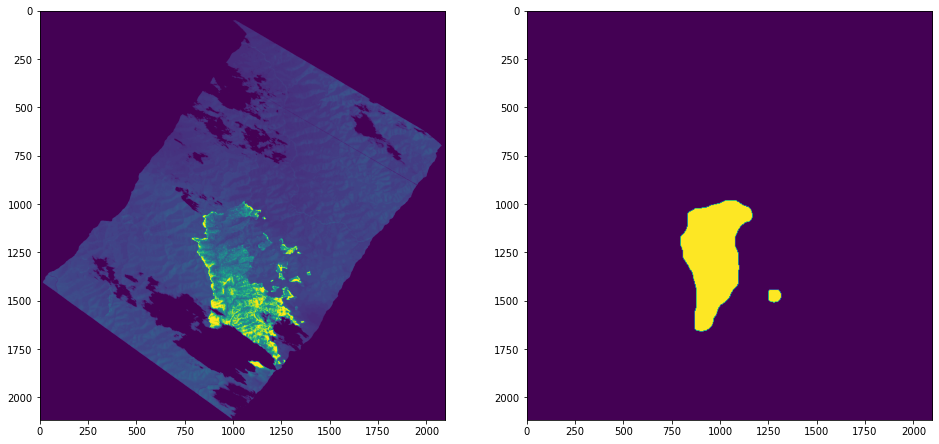

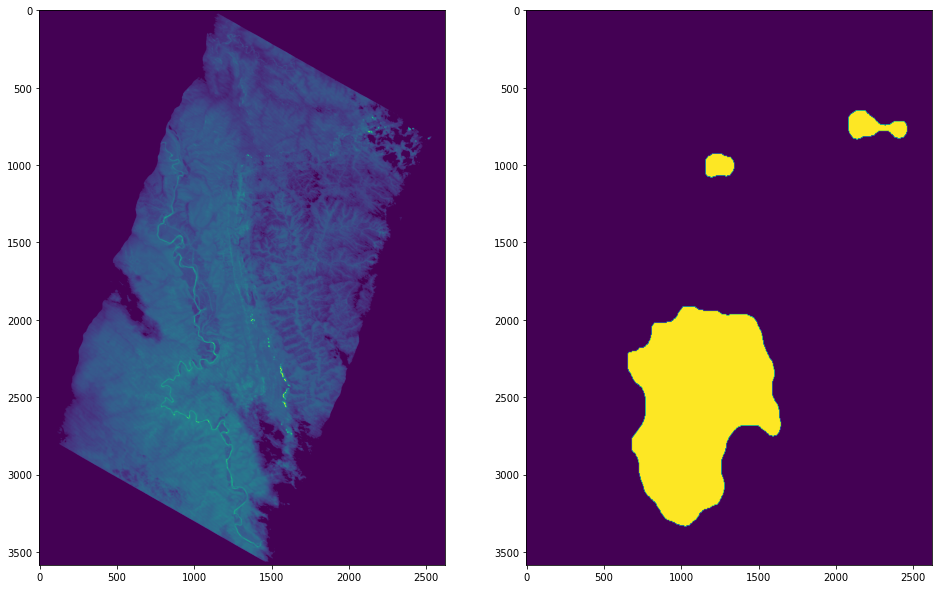

In [14]:
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
fnames = test.label.unique()
n = 0

for file_stem in fnames:
    
    src = dc.load(product='linescan', label=file_stem, output_crs='epsg:28355', resolution=(-10,10))
    mask = src.linescan   
    shape = mask.values[0].shape
    
    pred = np.where(preds[n] < threshold, 0, 1).astype(np.uint8)
    
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kopen,kopen))
    pred = cv2.morphologyEx(pred,cv2.MORPH_OPEN,kernelOpen)
    
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kclose,kclose))
    pred = cv2.morphologyEx(pred,cv2.MORPH_CLOSE,kernelClose)
    
    pred = resize(pred, shape, mode='constant', preserve_range=True)
    pred = pred.astype(np.bool)
    
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 2, 1)
    plt.imshow(src.linescan.values[0])
    f.add_subplot(1, 2, 2)
    plt.imshow(pred)
    plt.show(block=True)
    
    mask.values[0] = pred
    
    for idx, ob in test.loc[test.label==file_stem].iterrows():
        result_tf = mask.sel(x = ob.x, y = ob.y, method='nearest').values[0]
        result_10 = int(result_tf == True)
        test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10
    
    n += 1

In [15]:
test.target.value_counts()

0.0    4156
1.0     844
Name: target, dtype: int64

In [16]:
test.to_csv('submission.csv', columns = ['target'])